<a href="https://colab.research.google.com/github/Meghana-kanne/NLP/blob/main/ASSIGNMENT_5_4ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***IMPORT REQUIRED LIBRARIES***

In [1]:
import pandas as pd
import re
import nltk
import spacy
import matplotlib.pyplot as plt
from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


***Download NLTK Resources***

In [2]:
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

***Load Dataset & Extract Tweet Text***

In [3]:
# Load dataset
df = pd.read_csv("Tweets.csv")

# Extract tweet text column
tweets = df['text']

print("Total tweets:", len(tweets))
tweets.head()


Total tweets: 14640


,text
0,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...
3,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...


***Text Cleaning Function***

In [4]:
def clean_tweet(text):
    text = re.sub(r"http\S+|www\S+", "", text)     # Remove URLs
    text = re.sub(r"@\w+", "", text)               # Remove mentions
    text = re.sub(r"#", "", text)                  # Remove hashtag symbol
    text = re.sub(r"[^\w\s]", "", text)            # Remove emojis & punctuation
    text = text.lower().strip()
    return text

df['clean_text'] = df['text'].apply(clean_tweet)
df[['text', 'clean_text']].head()


,text,clean_text
0,@VirginAmerica What @dhepburn said.,what said
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...
2,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take another...
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it


***Word Tokenization (NLTK)***

In [6]:
nltk.download('punkt_tab')
df['tokens'] = df['clean_text'].apply(word_tokenize)
df['tokens'].head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,tokens
0,"[what, said]"
1,"[plus, youve, added, commercials, to, the, exp..."
2,"[i, didnt, today, must, mean, i, need, to, tak..."
3,"[its, really, aggressive, to, blast, obnoxious..."
4,"[and, its, a, really, big, bad, thing, about, it]"


***Stop Words Removal (NLTK)***

In [7]:
stop_words = set(stopwords.words('english'))

df['tokens_nostop'] = df['tokens'].apply(
    lambda tokens: [word for word in tokens if word not in stop_words]
)

df['tokens_nostop'].head()


,tokens_nostop
0,[said]
1,"[plus, youve, added, commercials, experience, ..."
2,"[didnt, today, must, mean, need, take, another..."
3,"[really, aggressive, blast, obnoxious, enterta..."
4,"[really, big, bad, thing]"


***Load spaCy Model***

In [8]:
nlp = spacy.load("en_core_web_sm")


***spaCy Pipeline Component(# DETECTION)***

In [9]:
from spacy.language import Language

@Language.component("hashtag_extractor")
def hashtag_extractor(doc):
    doc._.hashtags = [token.text for token in doc if token.text.startswith("#")]
    return doc

# Add custom extension
from spacy.tokens import Doc
Doc.set_extension("hashtags", default=[])

# Add component to pipeline
nlp.add_pipe("hashtag_extractor", last=True)

print(nlp.pipe_names)


['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'hashtag_extractor']


***Lemmatization & POS Tagging (spaCy)***

In [10]:
def spacy_process(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.is_alpha]
    pos_tags = [(token.text, token.pos_) for token in doc]
    return lemmas, pos_tags

df['lemmas'], df['pos_tags'] = zip(*df['clean_text'].apply(spacy_process))

df[['lemmas', 'pos_tags']].head()


,lemmas,pos_tags
0,"[what, say]","[(what, PRON), ( , SPACE), (said, VERB)]"
1,"[plus, you, ve, add, commercial, to, the, expe...","[(plus, CCONJ), (you, PRON), (ve, AUX), (added..."
2,"[I, do, not, today, must, mean, I, need, to, t...","[(i, PRON), (did, AUX), (nt, PART), (today, NO..."
3,"[its, really, aggressive, to, blast, obnoxious...","[(its, PRON), (really, ADV), (aggressive, ADJ)..."
4,"[and, its, a, really, big, bad, thing, about, it]","[(and, CCONJ), (its, PRON), (a, DET), (really,..."


***Rejoin Lemmatized Tokens***

In [11]:
df['final_text'] = df['lemmas'].apply(lambda x: " ".join(x))
df['final_text'].head()


,final_text
0,what say
1,plus you ve add commercial to the experience t...
2,I do not today must mean I need to take anothe...
3,its really aggressive to blast obnoxious enter...
4,and its a really big bad thing about it


***Hashtag Extraction & Visualization***

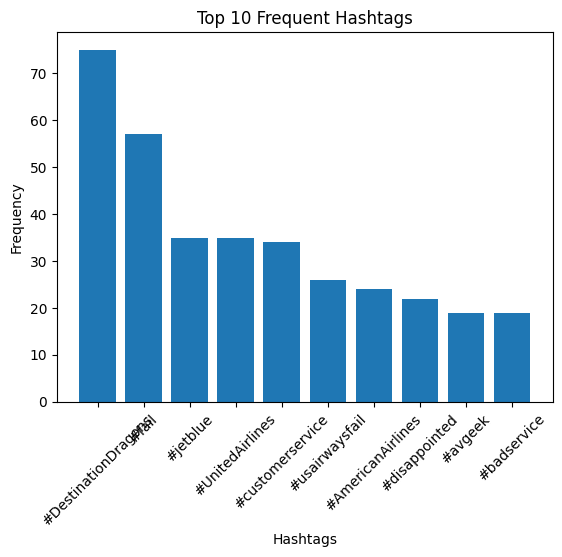

In [12]:
hashtags = []

for text in df['text']:
    hashtags.extend(re.findall(r"#\w+", text))

hashtag_freq = Counter(hashtags)

# Top 10 hashtags
top_hashtags = hashtag_freq.most_common(10)
tags, counts = zip(*top_hashtags)

plt.figure()
plt.bar(tags, counts)
plt.xticks(rotation=45)
plt.title("Top 10 Frequent Hashtags")
plt.xlabel("Hashtags")
plt.ylabel("Frequency")
plt.show()


***POS Distribution in Negative Tweets***

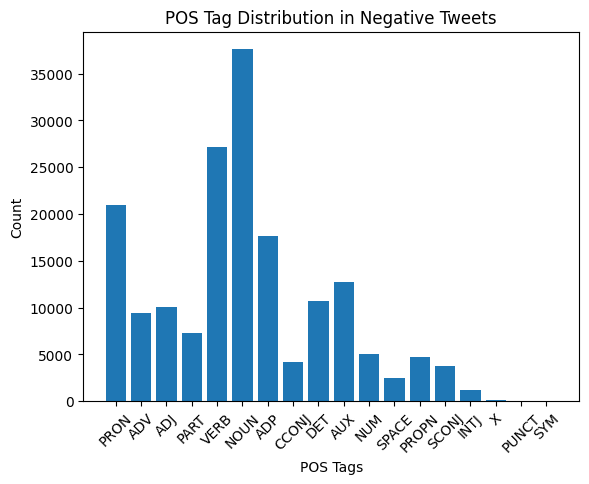

In [13]:
# Filter negative tweets
negative_df = df[df['airline_sentiment'] == 'negative']

pos_list = []

for tags in negative_df['pos_tags']:
    for word, pos in tags:
        pos_list.append(pos)

pos_freq = Counter(pos_list)

plt.figure()
plt.bar(pos_freq.keys(), pos_freq.values())
plt.xticks(rotation=45)
plt.title("POS Tag Distribution in Negative Tweets")
plt.xlabel("POS Tags")
plt.ylabel("Count")
plt.show()


***COMPLETE PIPELINE***

In [14]:
stop_words = set(stopwords.words('english'))

def complete_nlp_pipeline(text):
    # 1. Clean text
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^\w\s#]", "", text)
    text = text.lower().strip()

    # 2. Word Tokenization (NLTK)
    tokens = word_tokenize(text)

    # 3. Stopword Removal (NLTK)
    tokens_nostop = [word for word in tokens if word not in stop_words]

    # 4. spaCy Processing
    doc = nlp(" ".join(tokens_nostop))

    # 5. Lemmatization (spaCy)
    lemmas = [token.lemma_ for token in doc if token.is_alpha]

    # 6. POS Tagging (spaCy)
    pos_tags = [(token.text, token.pos_) for token in doc]

    # 7. Rejoin text
    final_text = " ".join(lemmas)

    return tokens, tokens_nostop, lemmas, pos_tags, final_text


In [16]:
df[['tokens',
    'tokens_nostop',
    'lemmas',
    'pos_tags',
    'final_text']] = df['text'].apply(
        lambda x: pd.Series(complete_nlp_pipeline(x))
    )

df[['text', 'final_text']].head()


,text,final_text
0,@VirginAmerica What @dhepburn said.,say
1,@VirginAmerica plus you've added commercials t...,plus you ve add commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,do not today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,really big bad thing
